# ID5059 Group Project: Temperature Prediction

### 1. Preprocessing

In [1]:
# import libraries
from pathlib import Path
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patheffects as PathEffects
import numpy as np
from scipy.interpolate import griddata
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

RANDOM_STATE = 1

#### 1.1 Load Data

In [2]:
# function reads in data from file
def load_data(file_name, file_path = "./", deliniator = ","):
    path = Path() / file_path / file_name; print(path)
    if not path.is_file():
        raise Exception("File not found")

    return pd.read_csv(path, sep = deliniator)

# reads in csv file containing data
file_path = "./"
file_name = "train.csv"
data = load_data(file_name, file_path = file_path, deliniator = ",")

# split the data into training and validation sets
data_train, data_valid = train_test_split(data)
data_explore = data_train.copy(deep = True)

train.csv


In [3]:
print(f"data_train:{data_explore.shape}, data_valid:{data_valid.shape}")
data_explore.head(2)

data_train:(9966690, 13), data_valid:(3322230, 13)


id           valid_time  latitude  longitude        tp  \
7275882  7275883  2018-07-19 20:00:00     57.00       -2.5  0.000000   
5420560  5420561  2018-05-29 21:00:00     57.25        0.0  0.000004   

              u10       v10         sp     u100      v100       tcc  ptype  \
7275882  2.425186  3.017700   99387.00  4.72522  4.682892  0.265015    0.0   
5420560 -3.505035 -6.952423  102139.94 -4.75029 -8.655548  0.785767    1.0   

              t2m  
7275882  291.8225  
5420560  285.2129

#### 1.2 Drop Unique Identifier
we see in the preview of the data above that there is a unique identifier -- this needs to be dropped in order to accurately train our models.

In [4]:
# drop unique identifier
columns_to_drop = ["id"]
data_explore.drop("id", axis = 1, inplace = True)

#### 1.3 Check for Null/Empty Values

In [5]:
# Check data types, summary statistics, and for missing values in the dataset
print(f"\tTraining data types:\n{data_explore.dtypes}")
print(f"\n\tSummary statistics for numerical columns:\n{data_explore.describe()}")
print(f"\n\tMissing values in training data:\n{data_explore.isnull().sum()}")

	Training data types:
valid_time     object
latitude      float64
longitude     float64
tp            float64
u10           float64
v10           float64
sp            float64
u100          float64
v100          float64
tcc           float64
ptype         float64
t2m           float64
dtype: object

	Summary statistics for numerical columns:
           latitude     longitude            tp           u10           v10  \
count  9.966690e+06  9.966690e+06  9.966690e+06  9.966690e+06  9.966690e+06   
mean   5.450008e+01 -3.000094e+00  1.153839e-04  1.055116e+00  1.494253e+00   
std    2.669402e+00  2.958035e+00  3.215029e-04  5.056120e+00  4.823389e+00   
min    5.000000e+01 -8.000000e+00  0.000000e+00 -1.932945e+01 -1.907394e+01   
25%    5.225000e+01 -5.500000e+00  0.000000e+00 -2.051163e+00 -1.639389e+00   
50%    5.450000e+01 -3.000000e+00  3.814697e-06  1.157471e+00  1.339256e+00   
75%    5.675000e+01 -5.000000e-01  6.437302e-05  4.235031e+00  4.461716e+00   
max    5.900000e+01  2.0

#### 1.4 Convert valid_time into More Usable Columns/Implement Seasons
The valid_time column is not currently in a format that is particularly helpful. Want to split into year, month, day, hour, and season categories -- these categories are unorded, and should later be one hot encoded.

In [6]:
# create function to separate the valid_time values into their components
# compatible with FunctionTransformer for use in pipeline
def extract_datetime_features(series):
    series = pd.to_datetime(series.squeeze())
    return pd.DataFrame({
        "year":   series.dt.year,
        "month":  series.dt.month,
        "day":    series.dt.day,
        "hour":   series.dt.hour,
        "season": ((series.dt.month % 12) // 3) + 1
    })

# adds the new temporal data
data_explore = pd.concat( [data_explore, extract_datetime_features(pd.Series(data_explore["valid_time"], name = "valid_time"))], axis = 1 )

# valid_time is not usable, therefore dropped
columns_to_drop = ["valid_time"]
data_explore.drop("valid_time", axis = 1, inplace = True)
data_explore.head(2)

latitude  longitude        tp       u10       v10         sp  \
7275882     57.00       -2.5  0.000000  2.425186  3.017700   99387.00   
5420560     57.25        0.0  0.000004 -3.505035 -6.952423  102139.94   

            u100      v100       tcc  ptype       t2m  year  month  day  hour  \
7275882  4.72522  4.682892  0.265015    0.0  291.8225  2018      7   19    20   
5420560 -4.75029 -8.655548  0.785767    1.0  285.2129  2018      5   29    21   

         season  
7275882       3  
5420560       2

#### 1.5 Plot Distribution of Variables

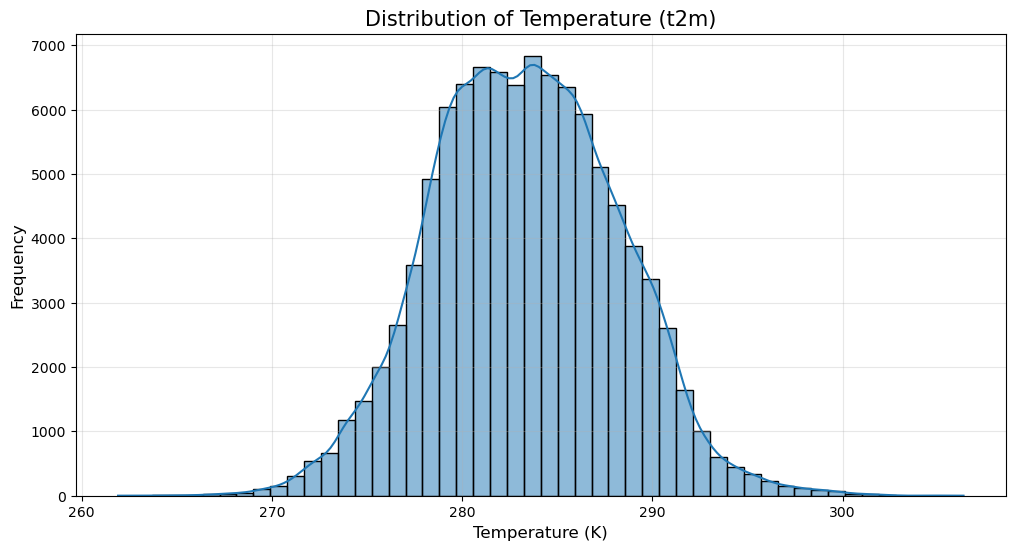

In [7]:
# distribution of temperature variable
plt.figure(figsize =(12, 6))
sns.histplot(data_explore['t2m'].sample(n = int(0.01 * data_explore.shape[0]), random_state = RANDOM_STATE), kde = True, bins = 50)
plt.title('Distribution of Temperature (t2m)', fontsize = 15)
plt.xlabel('Temperature (K)', fontsize = 12)
plt.ylabel('Frequency', fontsize = 12)
plt.grid(True, alpha = 0.3)
plt.show()

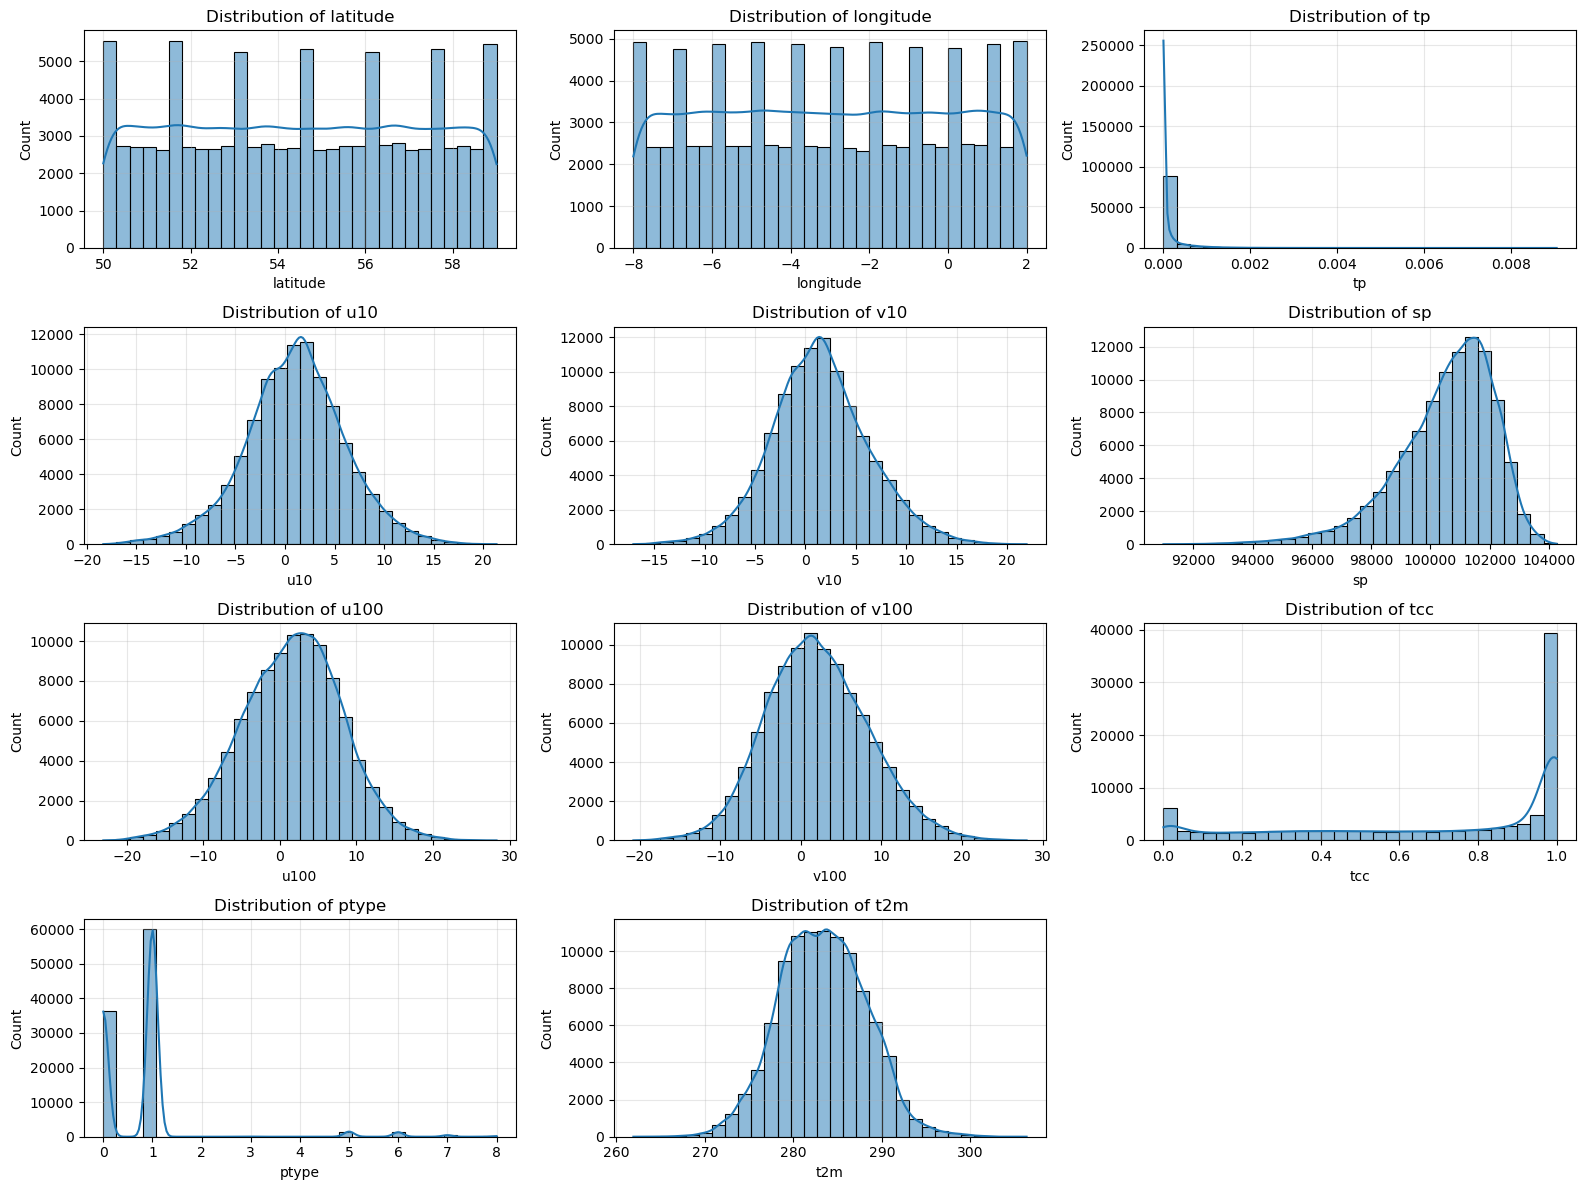

In [8]:
# Create a function to plot histograms for all numerical features
def plot_feature_distributions(df, columns=None, bins=30, figsize=(16, 12)):
    if columns is None:
        columns = df.select_dtypes(include=['float64', 'int64']).columns.tolist()

    n_cols = 3
    n_rows = (len(columns) + n_cols - 1) // n_cols

    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    axes = axes.flatten()

    for i, col in enumerate(columns):
        sns.histplot(df[col], kde=True, bins=bins, ax=axes[i])
        axes[i].set_title(f'Distribution of {col}', fontsize=12)
        axes[i].grid(True, alpha=0.3)

    # Hide unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()


# Plot distributions of all continuous features (excluding datetime and ID)
numeric_cols = data_explore.select_dtypes(include=['float64', 'int64']).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['id', 'year', 'month', 'day', 'hour', 'dayofweek', 'dayofyear']]
plot_feature_distributions( data_explore.sample(n = int(0.01 * data_explore.shape[0]), random_state = RANDOM_STATE), columns=numeric_cols )

#### 1.6 Plot Variables with Respect to Temperature

['latitude', 'longitude', 'tp', 'u10', 'v10', 'sp', 'u100', 'v100', 'tcc', 'ptype', 'year', 'month', 'day', 'hour', 'season']


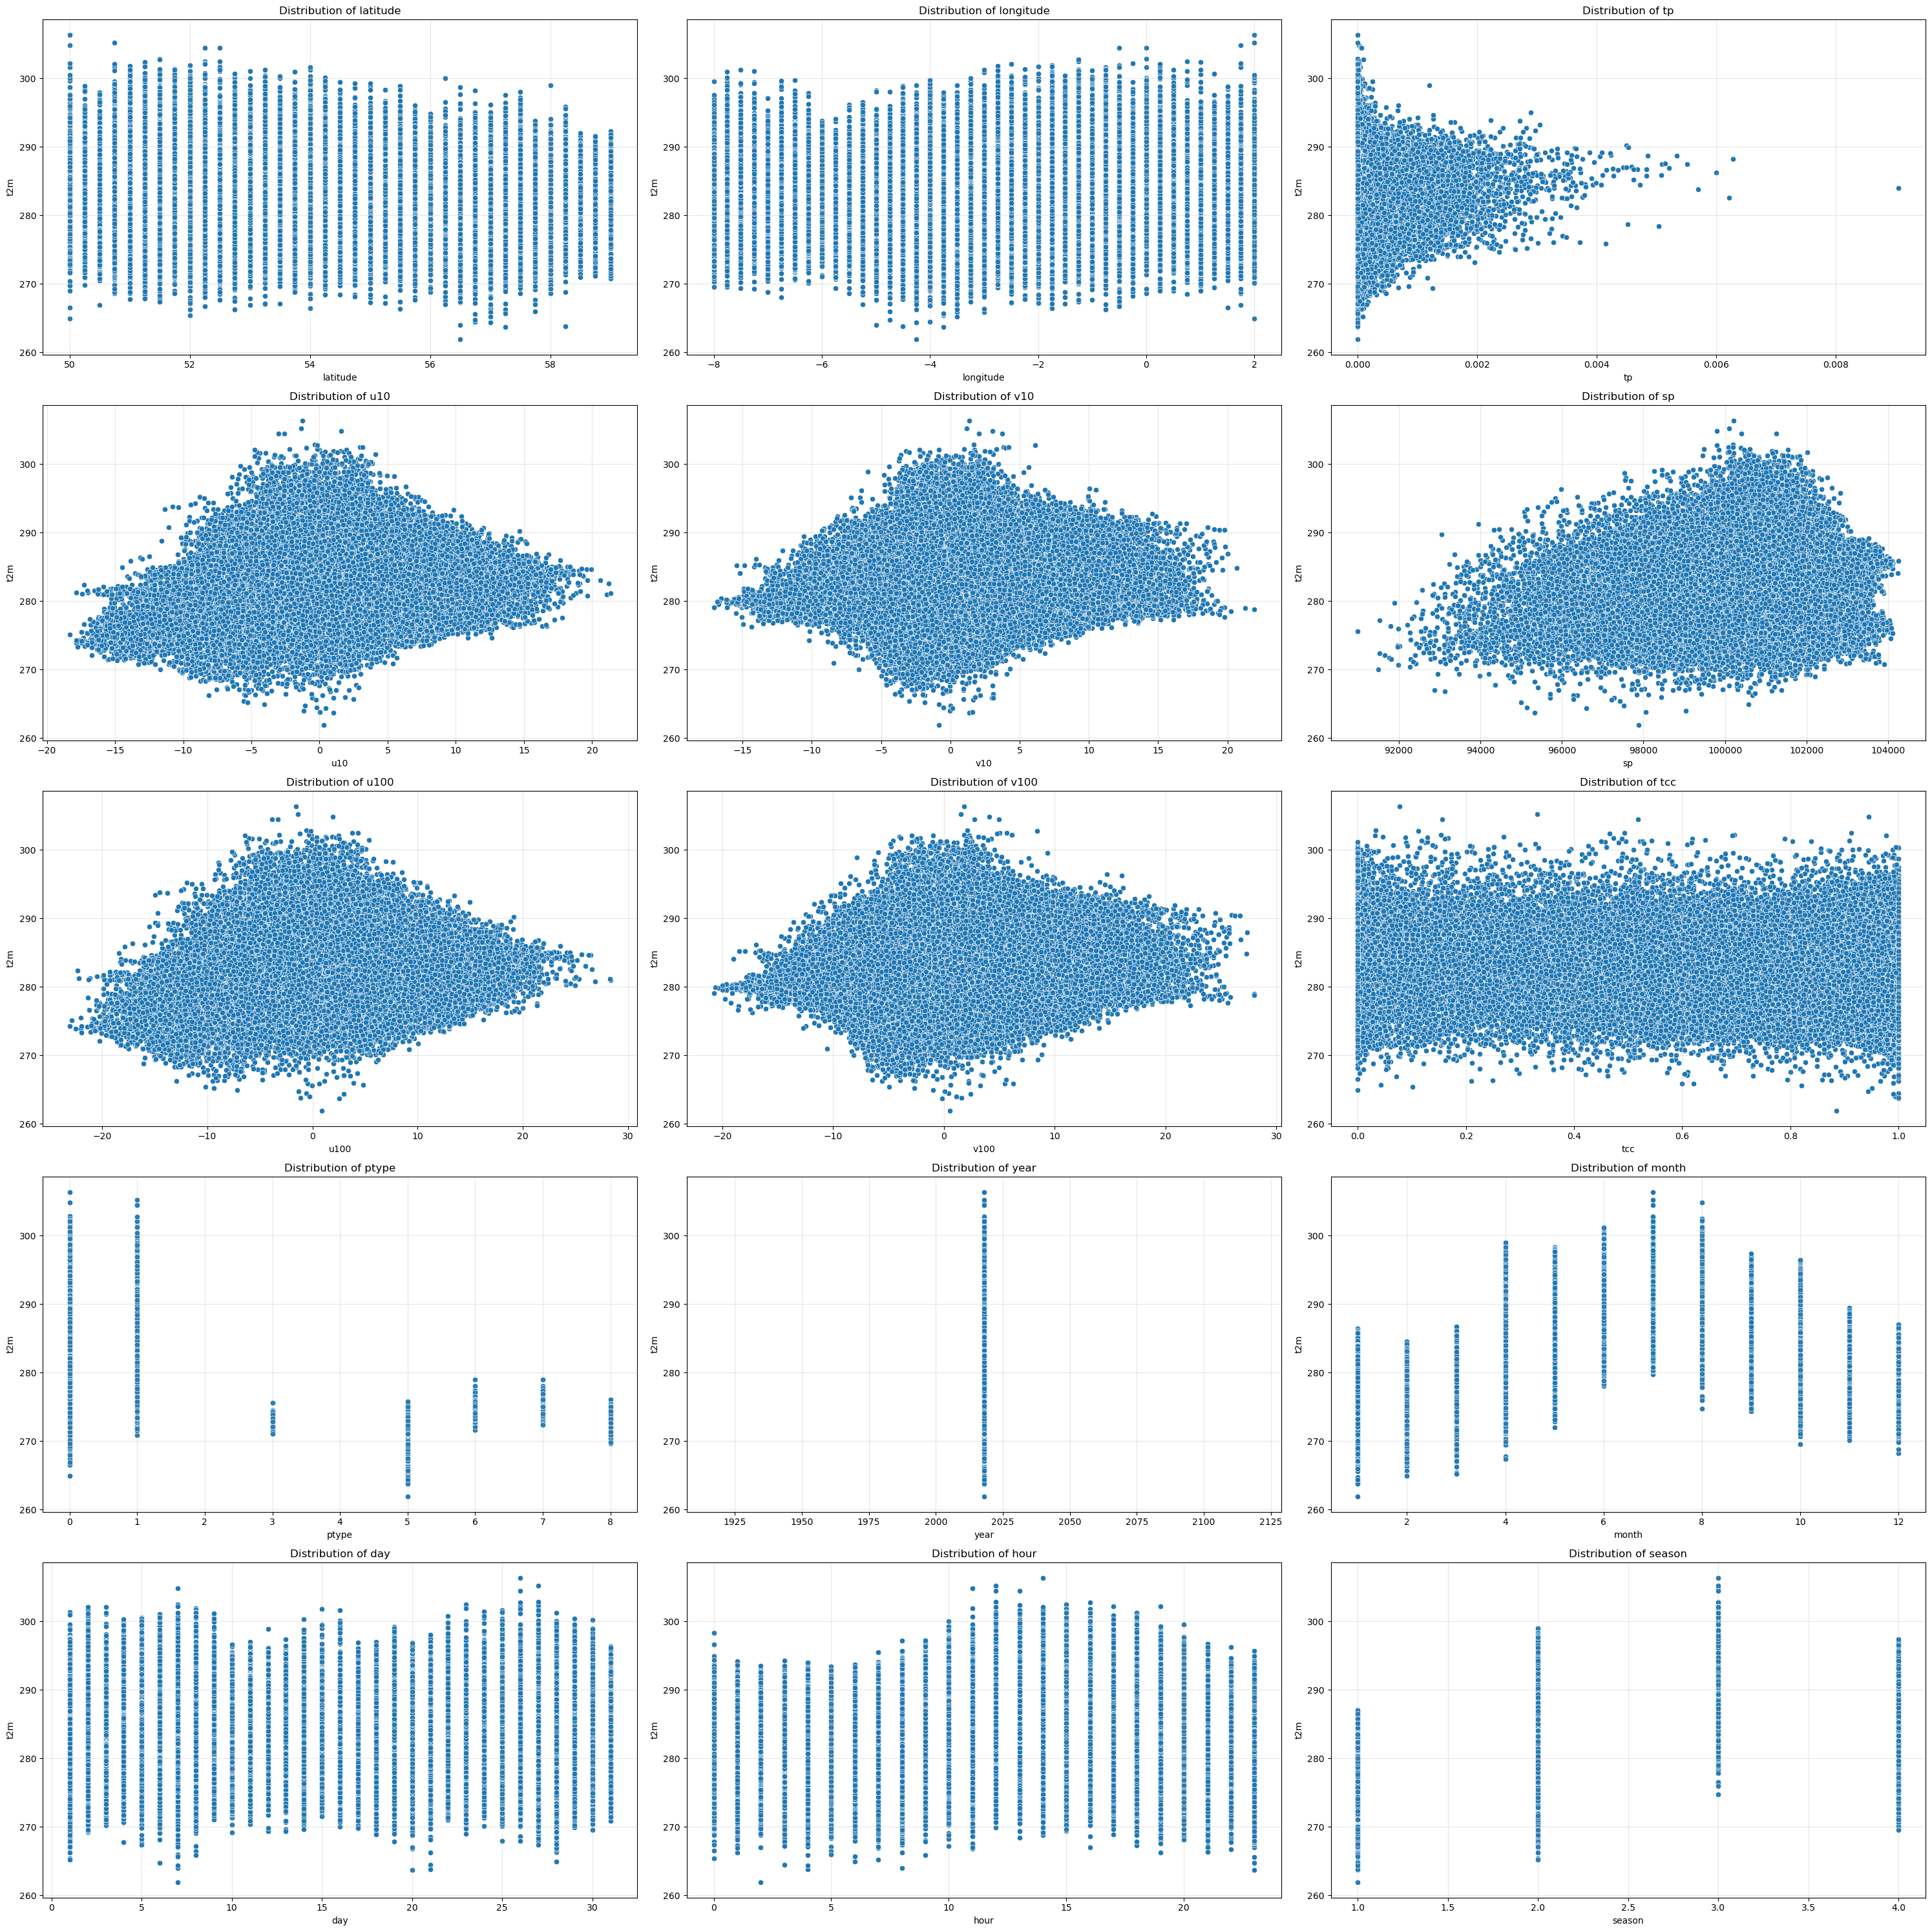

In [9]:
# plotting distributions for each variable
# running with all entries in dataset takes >10mins
# therefore run with random sample n from dataset to get an understanding of underlying shape
plottingVariables = list(filter(lambda item: item not in ["t2m",], list(data_explore.columns)))
print(plottingVariables)

n_cols = 3
n_rows = (len(plottingVariables) + n_cols - 1) // n_cols

# make a plot of each variable (excluding temperature) against temperature
fig, axes = plt.subplots(n_rows, n_cols, figsize = (30, 30))
axes = axes.flatten()
for i, variable in enumerate(plottingVariables):

    N0 = 0.01
    N = int(0.01 * data_explore.shape[0])

    sns.scatterplot(x = data_explore[variable].sample(n = N, random_state = RANDOM_STATE),
                    y = data_explore["t2m"].sample(n = N, random_state = RANDOM_STATE), ax=axes[i])
    axes[i].set_title(f'Distribution of {variable}', fontsize=12)
    axes[i].grid(True, alpha=0.3)

# Hide unused subplots
for j in range(i + 1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()

#### 1.7 Plot Geographic Features

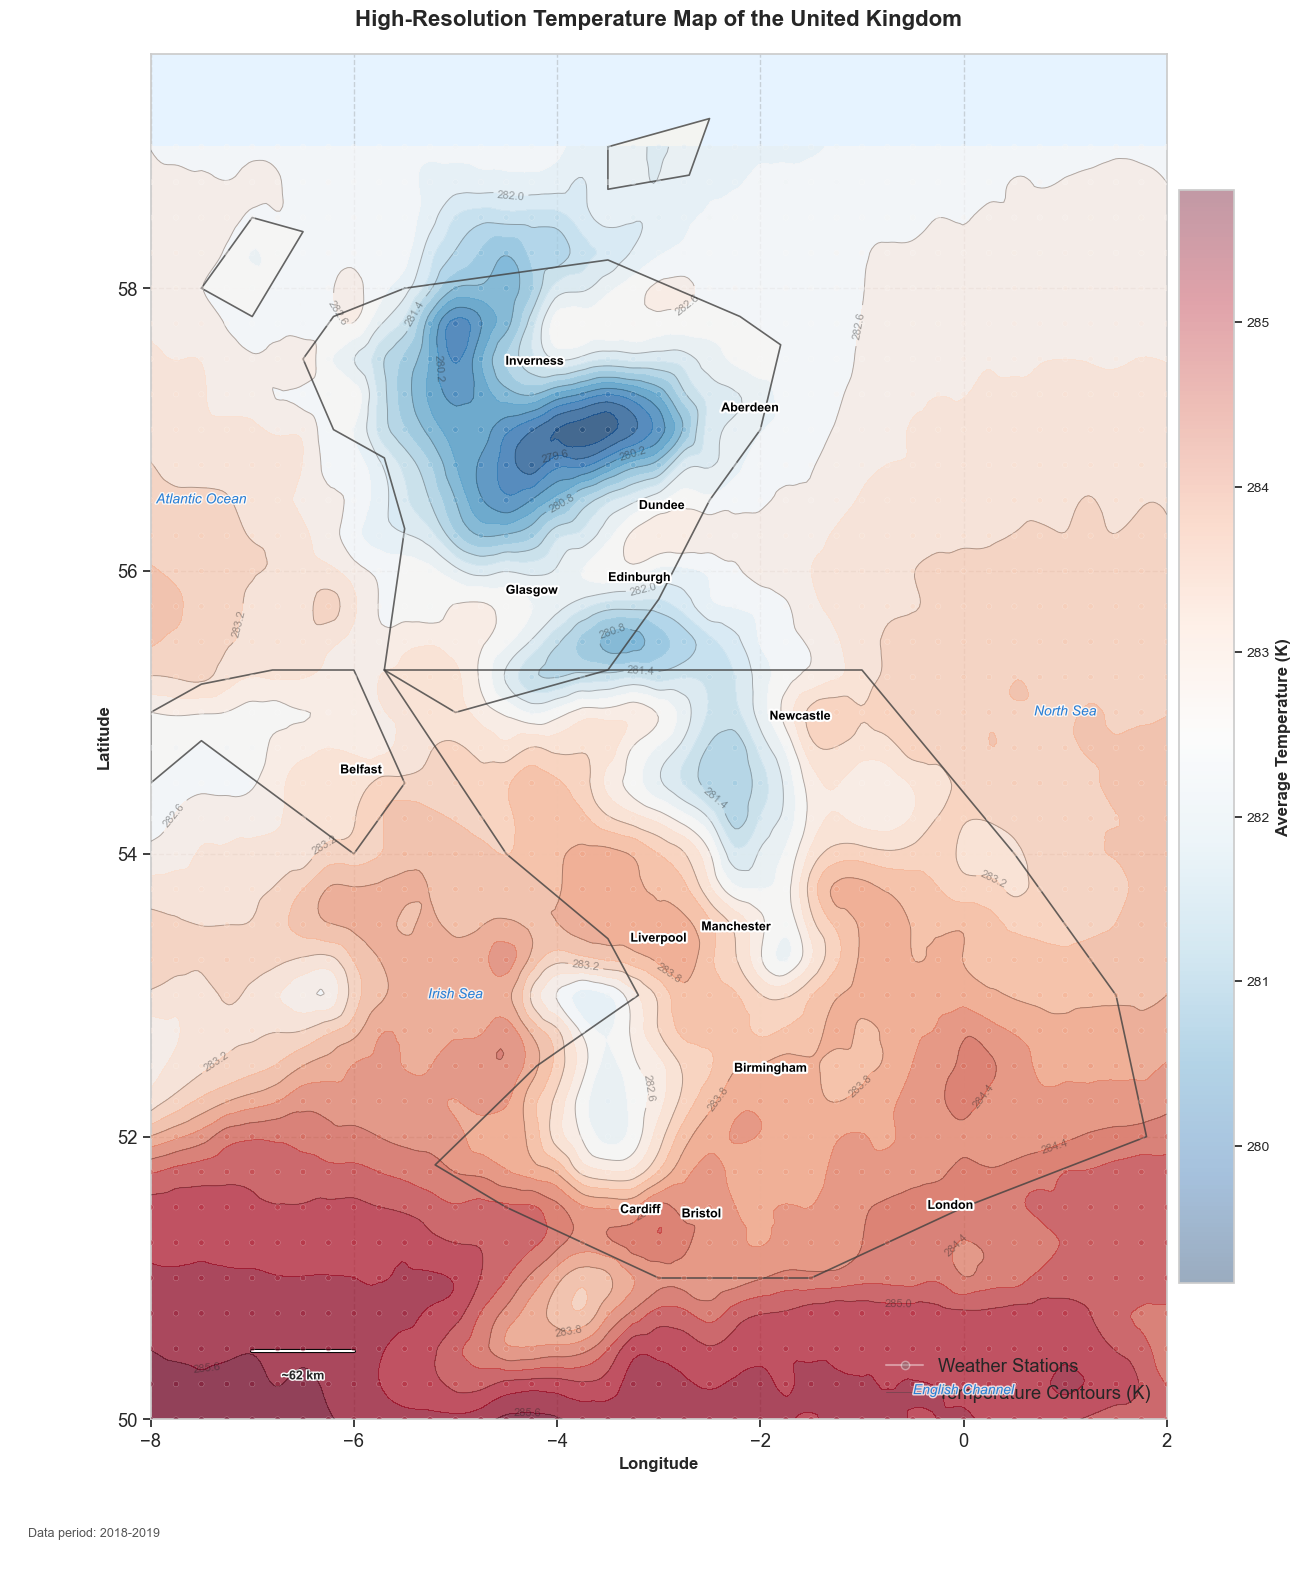

C:\Users\J\AppData\Local\Temp\ipykernel_20792\3292708852.py:256: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 0.95])


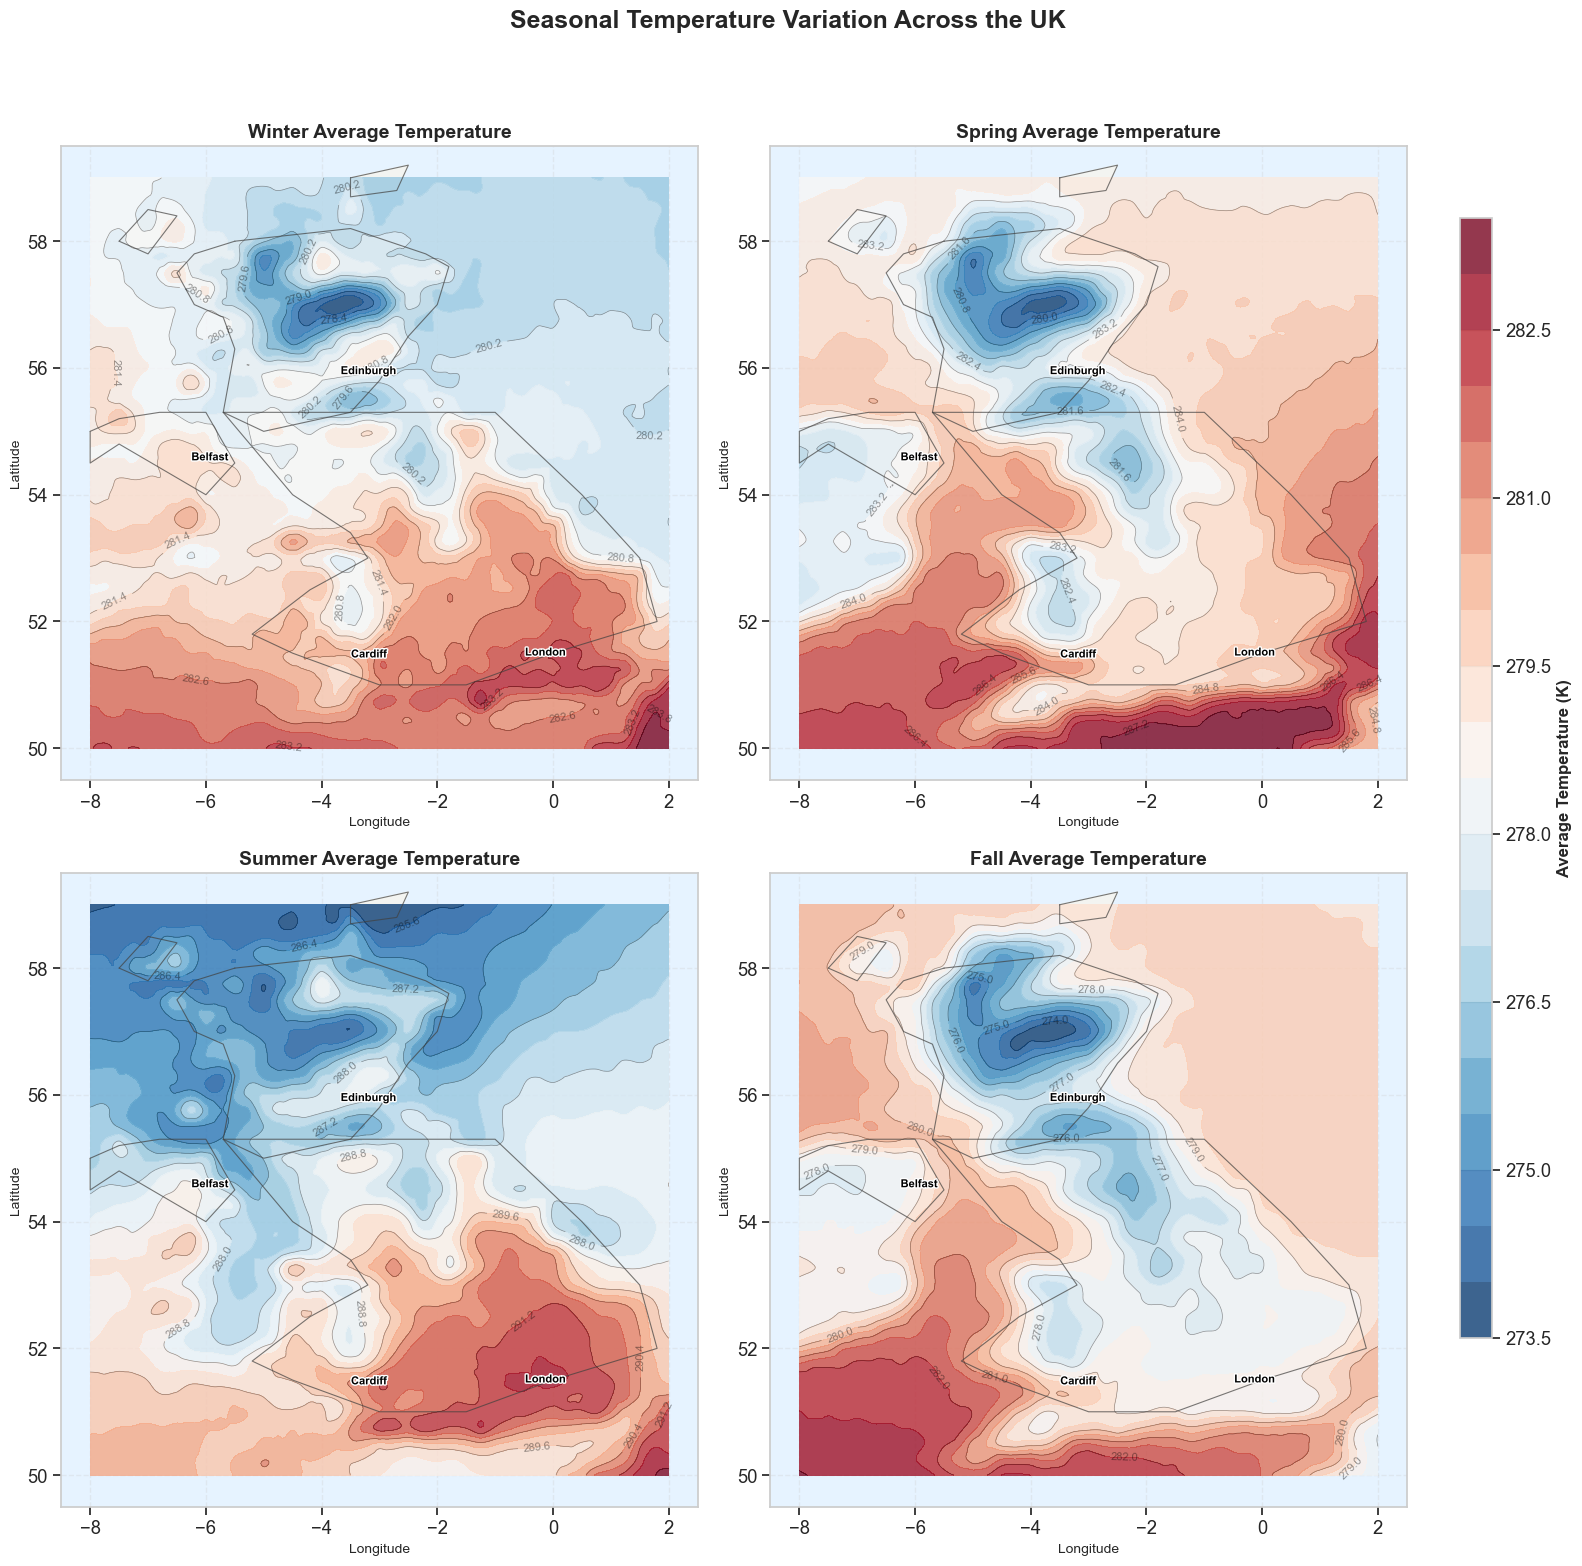

In [10]:
# Set figure aesthetics
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)

# Prepare the data
temp_by_location = data_explore.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

# Create a custom colormap for temperature
colors = ['#053061', '#2166ac', '#4393c3', '#92c5de', '#d1e5f0',
          '#f7f7f7', '#fddbc7', '#f4a582', '#d6604d', '#b2182b', '#67001f']
cmap = LinearSegmentedColormap.from_list('temp_cmap', colors, N=256)

# Create a higher resolution grid for smoother interpolation
grid_lon, grid_lat = np.meshgrid(
    np.linspace(temp_by_location.longitude.min(), temp_by_location.longitude.max(), 300),
    np.linspace(temp_by_location.latitude.min(), temp_by_location.latitude.max(), 300)
)

# Interpolate temperature values to the grid using cubic interpolation
grid_temp = griddata(
    (temp_by_location.longitude, temp_by_location.latitude),
    temp_by_location.t2m,
    (grid_lon, grid_lat),
    method='cubic'
)

# Create detailed UK outline
uk_outline = {
    # More detailed Scotland outline
    'scotland': [
        (-5.5, 58.0), (-6.2, 57.8), (-6.5, 57.5), (-6.2, 57.0),
        (-5.7, 56.8), (-5.5, 56.3), (-5.7, 55.3), (-5.0, 55.0),
        (-3.5, 55.3), (-3.0, 55.8), (-2.5, 56.5), (-2.0, 57.0),
        (-1.8, 57.6), (-2.2, 57.8), (-3.5, 58.2), (-5.5, 58.0)
    ],
    # Enhanced England and Wales
    'england_wales': [
        (-5.7, 55.3), (-4.5, 54.0), (-3.5, 53.4), (-3.2, 53.0),
        (-4.2, 52.5), (-5.2, 51.8), (-4.5, 51.5), (-3.0, 51.0),
        (-1.5, 51.0), (0.0, 51.5), (1.8, 52.0), (1.5, 53.0),
        (0.5, 54.0), (-1.0, 55.3), (-5.7, 55.3)
    ],
    # Enhanced Northern Ireland
    'northern_ireland': [
        (-8.0, 55.0), (-7.5, 55.2), (-6.8, 55.3), (-6.0, 55.3),
        (-5.5, 54.5), (-6.0, 54.0), (-7.5, 54.8), (-8.0, 54.5), (-8.0, 55.0)
    ],
    # Add Outer Hebrides
    'outer_hebrides': [
        (-7.5, 58.0), (-7.0, 58.5), (-6.5, 58.4), (-7.0, 57.8), (-7.5, 58.0)
    ],
    # Add Orkney Islands
    'orkney': [
        (-3.5, 59.0), (-2.5, 59.2), (-2.7, 58.8), (-3.5, 58.7), (-3.5, 59.0)
    ]
}

# Create figure with larger size and custom background
plt.figure(figsize=(14, 16))
ax = plt.axes()

# Set ocean background color
ax.set_facecolor('#e6f3ff')  # Light blue for ocean

# Create a more sophisticated land effect before plotting data
for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
    coords = uk_outline[region]
    xs, ys = zip(*coords)
    # Land fill with subtle terrain effect
    plt.fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)  # Light beige/gray for land
    # Coastal highlight
    plt.plot(xs, ys, color='#404040', linewidth=1.2, alpha=0.8, zorder=3)

# Plot the interpolated temperature surface with improved aesthetics
contour = plt.contourf(grid_lon, grid_lat, grid_temp, levels=25, cmap=cmap, alpha=0.75, zorder=2)

# Add contour lines with labels
contour_lines = plt.contour(grid_lon, grid_lat, grid_temp, levels=12,
                           colors='#404040', alpha=0.4, linewidths=0.7, zorder=4)
plt.clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f', colors='#202020')

# Add data points (smaller and more subtle)
scatter = plt.scatter(
    temp_by_location.longitude,
    temp_by_location.latitude,
    c=temp_by_location.t2m,
    cmap=cmap,
    s=15,  # Smaller points
    alpha=0.4,  # More transparent
    edgecolor='white',
    linewidth=0.3,
    zorder=5
)

# Add major cities and landmarks
cities = {
    'London': (-0.13, 51.51),
    'Edinburgh': (-3.19, 55.95),
    'Cardiff': (-3.18, 51.48),
    'Belfast': (-5.93, 54.59),
    'Manchester': (-2.24, 53.48),
    'Glasgow': (-4.25, 55.86),
    'Liverpool': (-3.0, 53.4),
    'Birmingham': (-1.9, 52.48),
    'Bristol': (-2.58, 51.45),
    'Newcastle': (-1.61, 54.97),
    'Aberdeen': (-2.1, 57.15),
    'Inverness': (-4.22, 57.48),
    'Dundee': (-2.97, 56.46)
}

# Improved city labels with better visibility
for city, (lon, lat) in cities.items():
    # Check if city is within data bounds
    if (temp_by_location.longitude.min() <= lon <= temp_by_location.longitude.max() and
        temp_by_location.latitude.min() <= lat <= temp_by_location.latitude.max()):
        txt = plt.text(lon, lat, city, fontsize=9, ha='center', va='center',
                      color='black', weight='bold', zorder=10)
        # Add white outline for better visibility
        txt.set_path_effects([PathEffects.withStroke(linewidth=3, foreground='white')])

# Add main geographical features
geo_features = {
    'North Sea': (1.0, 55.0),
    'Atlantic Ocean': (-7.5, 56.5),
    'Irish Sea': (-5.0, 53.0),
    'English Channel': (0.0, 50.2)
}

for feature, (lon, lat) in geo_features.items():
    # Water features in blue, italic
    txt = plt.text(lon, lat, feature, fontsize=10, ha='center', va='center',
                  color='#0066cc', style='italic', alpha=0.8, zorder=9)
    txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add scale bar
scale_length_deg = 1.0  # Length in degrees longitude
lon_scale = np.cos(np.radians(56)) * 111  # km per degree longitude at this latitude
scale_length_km = lon_scale * scale_length_deg

# Position scale bar
x_min, x_max = plt.xlim()
y_min, y_max = plt.ylim()
scale_x_start = x_min + 0.1 * (x_max - x_min)
scale_y = y_min + 0.05 * (y_max - y_min)

# Draw scale bar with improved styling
plt.plot([scale_x_start, scale_x_start + scale_length_deg],
         [scale_y, scale_y], 'k-', linewidth=3)
plt.plot([scale_x_start, scale_x_start + scale_length_deg],
         [scale_y, scale_y], 'w-', linewidth=1.5)

# Add km label with shadow
scale_txt = plt.text(scale_x_start + scale_length_deg/2, scale_y - 0.2,
                    f'~{scale_length_km:.0f} km',
                    ha='center', fontsize=9, fontweight='bold')
scale_txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

# Add better gridlines
plt.grid(True, alpha=0.3, linestyle='--', color='gray')

# Add colorbar with better styling
cbar = plt.colorbar(scatter, pad=0.01, shrink=0.8, aspect=20)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')
cbar.ax.tick_params(labelsize=10)

# Add title and labels
plt.title('High-Resolution Temperature Map of the United Kingdom',
          fontsize=16, weight='bold', pad=20)
plt.xlabel('Longitude', fontsize=12, weight='bold')
plt.ylabel('Latitude', fontsize=12, weight='bold')

# Add legend
legend_elements = [
    plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='gray', markersize=6, alpha=0.4,
              label='Weather Stations'),
    plt.Line2D([0], [0], color='#404040', lw=0.7, alpha=0.4,
              label='Temperature Contours (K)')
]
plt.legend(handles=legend_elements, loc='lower right', framealpha=0.7)

# Add date info
plt.annotate('Data period: 2018-2019', xy=(0.02, 0.02), xycoords='figure fraction',
            fontsize=9, color='#555555')

plt.tight_layout()
plt.show()

# Create a second visualization showing seasonal temperature variation
seasons = {
    'Winter': 2,
    'Spring': 4,
    'Summer': 3,
    'Fall': 1
}

# Create a figure for seasonal comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes = axes.flatten()

for i, (season_name, season) in enumerate(seasons.items()):
    # Get data for this season
    season_data = data_explore[data_explore['season'] == season]
    season_temp = season_data.groupby(['latitude', 'longitude'])['t2m'].mean().reset_index()

    # Interpolate to grid
    season_grid = griddata(
        (season_temp.longitude, season_temp.latitude),
        season_temp.t2m,
        (grid_lon, grid_lat),
        method='cubic'
    )

    # Set background color
    axes[i].set_facecolor('#e6f3ff')

    # Add UK land
    for region in ['england_wales', 'scotland', 'northern_ireland', 'outer_hebrides', 'orkney']:
        coords = uk_outline[region]
        xs, ys = zip(*coords)
        axes[i].fill(xs, ys, color='#f5f5f0', alpha=0.9, zorder=1)
        axes[i].plot(xs, ys, color='#404040', linewidth=0.8, alpha=0.7, zorder=3)

    # Plot contours
    contour = axes[i].contourf(grid_lon, grid_lat, season_grid, levels=20, cmap=cmap, alpha=0.8)

    # Add contour lines
    contour_lines = axes[i].contour(grid_lon, grid_lat, season_grid,
                                   levels=10, colors='black', alpha=0.4, linewidths=0.5)
    axes[i].clabel(contour_lines, inline=True, fontsize=8, fmt='%.1f')


    # Add city markers - just a few key cities for each subplot
    major_cities = {k: cities[k] for k in ['London', 'Edinburgh', 'Cardiff', 'Belfast']}
    for city, (lon, lat) in major_cities.items():
        if (season_temp.longitude.min() <= lon <= season_temp.longitude.max() and
            season_temp.latitude.min() <= lat <= season_temp.latitude.max()):
            txt = axes[i].text(lon, lat, city, fontsize=8, ha='center', va='center',
                         color='black', weight='bold', zorder=7)
            txt.set_path_effects([PathEffects.withStroke(linewidth=2, foreground='white')])

    # Set limits and labels
    axes[i].set_xlim(temp_by_location.longitude.min() - 0.5, temp_by_location.longitude.max() + 0.5)
    axes[i].set_ylim(temp_by_location.latitude.min() - 0.5, temp_by_location.latitude.max() + 0.5)
    axes[i].set_xlabel('Longitude', fontsize=10)
    axes[i].set_ylabel('Latitude', fontsize=10)
    axes[i].set_title(f'{season_name} Average Temperature', fontsize=14, weight='bold')
    axes[i].grid(True, alpha=0.3, linestyle='--')

# Add colorbar
cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig.colorbar(contour, cax=cbar_ax)
cbar.set_label('Average Temperature (K)', fontsize=12, weight='bold')

plt.suptitle('Seasonal Temperature Variation Across the UK', fontsize=18, weight='bold', y=0.98)
plt.tight_layout(rect=[0, 0, 0.9, 0.95])
plt.show()

#### 1.8 Create Pipeline

In [11]:
num_cols = [c for c in data_train.columns if c not in ["valid_time", "ptype", "t2m"]]

datetime_pipeline = Pipeline([
    ("extract_datetime", FunctionTransformer(extract_datetime_features, validate=False)),
    ("one_hot_encode", OneHotEncoder(handle_unknown="ignore", sparse_output = False))
])

numeric_pipeline = Pipeline([
    ("impute", SimpleImputer()),
    ("scale", StandardScaler())
])

preprocessor = ColumnTransformer([
    ("datetime", datetime_pipeline, ["valid_time"]),
    ("encode_ptype", OneHotEncoder(handle_unknown="ignore", sparse_output = False), ["ptype"]),
    ("numeric", numeric_pipeline, num_cols),
    ("drop_columns", "drop", columns_to_drop)
], remainder="drop", sparse_threshold = 0.0)

full_pipeline = Pipeline([
    ("preprocess", preprocessor)
])

# separating the response variable before using the pipeline on the training and validation sets
y_train = data_train["t2m"]
y_valid = data_valid["t2m"]

# using the pipeline on the training and validation sets
x_train = full_pipeline.fit_transform(data_train.drop("t2m", axis = 1))
x_valid = full_pipeline.transform(data_valid.drop("t2m", axis = 1))

In [12]:
print(x_train.shape)

(9966690, 89)


In [13]:
# checks to ensure that all of the data types are compatible for use in modelling
type(x_train) == type(x_valid) == type(y_train.to_numpy()) == type(y_valid.to_numpy())

True

#### 1.9 Save Results From Pipeline
Now that the data has been processed by the pipeline we want to save it so that it can be used for modelling without having to rerun this section of code every time it is to be used.

In [14]:
# saves each of the created datasets
file_path = "./"

# training set
file_name = "x_train.csv"
np.savetxt(fname = f"{file_path + file_name}", X = x_train, delimiter = ",")

file_name = "y_train.csv"
np.savetxt(fname = f"{file_path + file_name}", X = y_train.to_numpy(), delimiter = ",")

# validation set
file_name = "x_valid.csv"
np.savetxt(fname = f"{file_path + file_name}", X = x_valid, delimiter = ",")

file_name = "y_valid.csv"
np.savetxt(fname = f"{file_path + file_name}", X = y_valid.to_numpy(), delimiter = ",")

#### 1.10 Cluster Locations and Temperatures
***NOT INCLUDED IN ANALYSIS/PIPELINE BECAUSE OF DATALEAKAGE***

In [15]:
# function prints the silhouette score for a given range of k clusters
def findOptimalClusters(data, range):
  print(f"k:\tSilhouetteScore:")
  silhouetteScores = []

  for k in range:
    kmeans = KMeans(n_clusters = k, random_state = RANDOM_STATE, n_init = "auto")
    labels = kmeans.fit_predict(data)
    score = silhouette_score(data, labels)
    silhouetteScores.append(score)
    print(f"{k},\t{score:.3f}")

  return np.argmax(silhouetteScores) + range[0]


N0 = 0.001
N = int( N0 * data_train.shape[0] )

# turn latitude, longitude, and temperature into 3D coordinates
temperature_coordinates = data_explore[["latitude", "longitude", "t2m"]]
temperature_coordinates_sampled = temperature_coordinates.sample(n = N, random_state = RANDOM_STATE)

coordinateScaler = StandardScaler()
temperature_coordinates_scaled = coordinateScaler.fit_transform( temperature_coordinates ) # <- need to normalise coordinates to run kmeans
temperature_coordinates_sampled_scaled = coordinateScaler.transform( temperature_coordinates_sampled.values )

# use silhouette score score to find number of clusters
# takes a long time to run on whole data set hence sample coordinates
# use results from sampled data to infer the optimal result for whole dataset
optimalK = findOptimalClusters(temperature_coordinates_sampled_scaled, range(2, 11))
print(f"\noptimal k = {optimalK}")

c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\sklearn\utils\validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\joblib\externals\loky\backend\context.py:136: UserWarning: Could not find the number of physical cores for the following reason:
[WinError 2] The system cannot find the file specified
Returning the number of logical cores instead. You can silence this warning by setting LOKY_MAX_CPU_COUNT to the number of cores you want to use.
  warnings.warn(
  File "c:\Users\J\miniconda3\envs\ID5059\lib\site-packages\joblib\externals\loky\backend\context.py", line 257, in _count_physical_cores
    cpu_info = subprocess.run(
  File "c:\Users\J\miniconda3\envs\ID5059\lib\subprocess.py", line 503, in run
    with Popen(*popenargs, **kwargs) as process:
  File "c:\Users\J\miniconda3\envs\ID5059\lib\subprocess.py", line 971, in __init__
    self._execute_

k:	SilhouetteScore:
2,	0.251
3,	0.263
4,	0.279
5,	0.286
6,	0.270
7,	0.273
8,	0.265
9,	0.264
10,	0.255

optimal k = 5


In [16]:
# now clustering over whole dataset
kmeans = KMeans(n_clusters = optimalK, random_state = RANDOM_STATE, n_init = "auto")
coordinate_data = kmeans.fit_predict(temperature_coordinates_scaled)

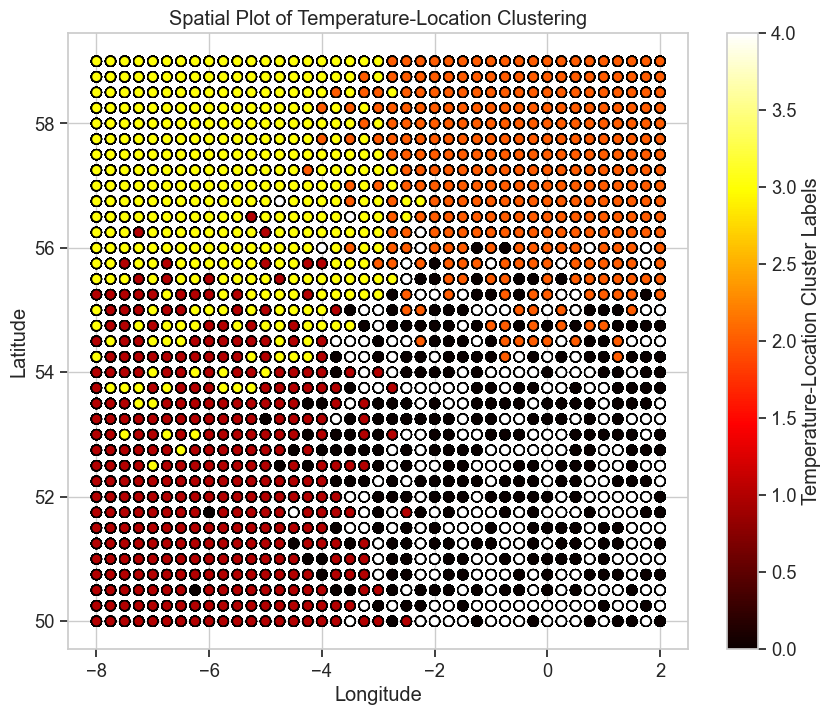

In [17]:
N0 = 0.01
N = int( N0 * data_train.shape[0] )

plt.figure(figsize=(10, 8))
scatter = plt.scatter(data_explore.sample(n = N, random_state = RANDOM_STATE)["longitude"],
                      data_explore.sample(n = N, random_state = RANDOM_STATE)["latitude"],
                      c = pd.DataFrame(coordinate_data).sample(n = N, random_state = RANDOM_STATE),
                      cmap = "hot", s = 50, edgecolor = "k")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Spatial Plot of Temperature-Location Clustering")
plt.colorbar(scatter, label= "Temperature-Location Cluster Labels")
plt.grid(True)
plt.show()